In [12]:
import praw

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from pydantic import BaseModel, Field, ValidationError
from typing import Literal

import ollama

In [4]:
import logging
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
for logger_name in ("praw", "prawcore"):
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.DEBUG)
    logger.addHandler(handler)

In [5]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [5]:
client_id = os.getenv("REDDIT_CLIENT_ID")
client_secret = os.getenv("REDDIT_CLIENT_SECRET")


In [6]:
reddit = praw.Reddit(
client_id =client_id,
client_secret = client_secret,
user_agent='Windows:reddit_bitcoin_scraper:v1 (by /u/Critical_Product_103)',
)

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


In [7]:
subreddits_of_interest = ["bitcoin", "cryptocurrency"]

In [8]:
subreddits = reddit.subreddit("+".join(subreddits_of_interest))

In [9]:
start_date = '2024-01-01'
start_date = pd.to_datetime(start_date).tz_localize('UTC')

In [10]:
posts_by_date = defaultdict(list)

for post in subreddits.top(time_filter= "year", limit=None):
    post_date = pd.to_datetime(post.created_utc, unit='s', utc=True)

    if post_date > start_date:
        # Collect the details of the post without comments
        post_data = {
            "post_id": post.id,  # Post ID
            "title": post.title,
            "body": post.selftext if post.selftext else "No text body (link post)",
            "author": post.author.name if post.author else "Unknown",  # Post author
            "upvotes": post.ups,  # Number of upvotes
            "downvotes": post.downs,  # Number of downvotes
            "score": post.score,  # Post score (upvotes - downvotes)
            "num_comments": post.num_comments,  # Number of comments
            "url": post.url,  # URL of the post
            "created_at": post_date,  # Post creation date
            "subreddit": post.subreddit.display_name,  # Subreddit name
        }

        # Append to the respective date key
        posts_by_date[post_date].append(post_data)
    
    else:
        continue

Fetching: GET https://oauth.reddit.com/r/bitcoin+cryptocurrency/top at 1741680188.4072523
Data: None
Params: {'limit': 1024, 'raw_json': 1, 't': 'year'}
Response: 200 (75233 bytes) (rst-410:rem-999.0:used-1 ratelimit) at 1741680191.5840585
Fetching: GET https://oauth.reddit.com/r/bitcoin+cryptocurrency/top at 1741680191.600109
Data: None
Params: {'after': 't3_1hqdmpr', 'limit': 1024, 'raw_json': 1, 't': 'year'}
Response: 200 (68873 bytes) (rst-407:rem-998.0:used-2 ratelimit) at 1741680194.004602
Fetching: GET https://oauth.reddit.com/r/bitcoin+cryptocurrency/top at 1741680194.0185943
Data: None
Params: {'after': 't3_1hz6sge', 'limit': 1024, 'raw_json': 1, 't': 'year'}
Response: 200 (66102 bytes) (rst-404:rem-997.0:used-3 ratelimit) at 1741680196.2371023
Fetching: GET https://oauth.reddit.com/r/bitcoin+cryptocurrency/top at 1741680196.2491007
Data: None
Params: {'after': 't3_1gpisaz', 'limit': 1024, 'raw_json': 1, 't': 'year'}
Response: 200 (69057 bytes) (rst-402:rem-996.0:used-4 rateli

In [11]:
df = pd.DataFrame([p for posts in posts_by_date.values() for p in posts])


In [12]:
df

,post_id,title,body,author,upvotes,downvotes,score,num_comments,url,created_at,subreddit
0,1h6ykx6,Bitcoin Hit 100k,No text body (link post),Physical-Average2495,53459,0,53459,3743,https://i.redd.it/jk2phdu8zx4e1.jpeg,2024-12-05 02:34:23+00:00,Bitcoin
1,1hpfduu,Just found an old wallet from 7 years ago,"Long story short, just found this wallet. Movi...",Van_man_dan_,48179,0,48179,1811,https://www.reddit.com/gallery/1hpfduu,2024-12-30 04:50:18+00:00,Bitcoin
2,1h7a4vn,The Bitcoin $100 and Bitcoin $100K side by sid...,No text body (link post),No-Comparison-9307,39274,0,39274,761,https://v.redd.it/oj1m38vdg15e1,2024-12-05 14:16:12+00:00,Bitcoin
3,1h7ggy9,Hawk Tuah Girl responds as people call for her...,No text body (link post),Abdeliq,28112,0,28112,4983,https://www.unilad.com/technology/news/hawk-tu...,2024-12-05 18:46:02+00:00,CryptoCurrency
4,1f3f91t,Kamala Harris proposes 25% tax on unrealized g...,No text body (link post),InclineDumbbellPress,21196,0,21196,2632,https://finbold.com/kamala-harris-proposes-25-...,2024-08-28 16:55:02+00:00,CryptoCurrency
...,...,...,...,...,...,...,...,...,...,...,...
1738,1h0o852,Rumble to invest up to $20 million in Bitcoin ...,No text body (link post),Odd-Radio-8500,430,0,430,38,https://cryptobriefing.com/rumble-invests-bitc...,2024-11-26 22:04:54+00:00,CryptoCurrency
1739,1gqe56f,I bought $1k of the Top 10 Cryptos on January ...,[EXPERIMENT - Tracking 2024 Top Ten Cryptocurr...,Joe-M-4,425,0,425,65,https://www.reddit.com/r/CryptoCurrency/commen...,2024-11-13 14:30:27+00:00,CryptoCurrency
1740,1e3n0q1,Bitcoin Soars Above $61K Causing Over $100 Mil...,The Bitcoin price has recovered above the pivo...,hiorea,428,0,428,90,https://cryptopotato.com/bitcoin-soars-above-6...,2024-07-15 05:32:28+00:00,CryptoCurrency
1741,1dv8fhw,Bitcoin wobbles at $57K as liquidations reach ...,No text body (link post),0xJonnyDee,429,0,429,133,https://cryptobriefing.com/crypto-market-liqui...,2024-07-04 14:36:36+00:00,CryptoCurrency


In [53]:
df['date_created'] = df['created_at'].dt.date
df_sorted = df.sort_values(by=['date_created','created_at']).reset_index(drop=True)

In [54]:
df_sorted.value_counts('date_created')

date_created
2024-12-05    33
2024-11-22    23
2024-11-21    21
2024-11-10    20
2024-12-20    19
              ..
2024-05-23     1
2024-05-25     1
2024-05-24     1
2024-04-28     1
2024-04-27     1
Name: count, Length: 306, dtype: int64

In [55]:
df_sorted

,post_id,title,body,author,upvotes,downvotes,score,num_comments,url,created_at,subreddit,date_created
0,1bc103l,Loopring (LRC) Receives a Very Bullish Rating ...,No text body (link post),trrrring,447,0,447,266,https://www.investorsobserver.com/news/crypto-...,2024-03-11 11:30:40+00:00,CryptoCurrency,2024-03-11
1,1bc1p7r,"MicroStrategy acquires additional 12,000 BTC a...",No text body (link post),InfinityLife,1892,0,1892,282,https://i.redd.it/jbgpax4t4pnc1.png,2024-03-11 12:11:51+00:00,Bitcoin,2024-03-11
2,1bc26g8,crypto cap hits 2.7+ trillion. highest since n...,No text body (link post),csmonigo,769,0,769,139,https://www.coingecko.com/en/global-charts,2024-03-11 12:38:06+00:00,CryptoCurrency,2024-03-11
3,1bc3une,"MicroStrategy has acquired an additional 12,00...",No text body (link post),Vipu2,486,0,486,75,https://twitter.com/saylor/status/176715887029...,2024-03-11 13:59:44+00:00,CryptoCurrency,2024-03-11
4,1bc58w0,No one still gives a shit about BTC. (bullish),I'm celebrating new BTC all time highs today a...,ultron290196,1962,0,1962,691,https://www.reddit.com/r/Bitcoin/comments/1bc5...,2024-03-11 15:01:46+00:00,Bitcoin,2024-03-11
...,...,...,...,...,...,...,...,...,...,...,...,...
1738,1i9ljf9,BTC,No text body (link post),Late-Election-4690,3489,0,3489,59,https://i.redd.it/mei5efrcr4fe1.jpeg,2025-01-25 12:04:03+00:00,Bitcoin,2025-01-25
1739,1i9onno,Ethereum (ETH) Holders,No text body (link post),kirtash93,4200,0,4200,239,https://i.redd.it/l5vbdbr9m5fe1.png,2025-01-25 14:57:23+00:00,CryptoCurrency,2025-01-25
1740,1i9q2gt,'A mockery': Trump's new meme-coin sparks ange...,No text body (link post),4inalfantasy,1760,0,1760,341,https://www.bbc.com/news/articles/crlkjejpwr8o,2025-01-25 16:02:00+00:00,CryptoCurrency,2025-01-25
1741,1i9qktl,Epic new Bitcoin ad. They keep getting better 🙌,No text body (link post),BitCypher84,1634,0,1634,156,https://v.redd.it/2blk43pq16fe1,2025-01-25 16:24:24+00:00,Bitcoin,2025-01-25


In [13]:
model_name = "llama3.1:8b"

def classify_post(title, body):
    prompt = f"Determine if this Reddit post is relevant to Bitcoin news:\nTitle: {title}\nBody: {body}\nAnswer 'Yes' or 'No'."
    response = ollama.chat(model=model_name, messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"]

In [18]:
df_sorted['is_relevant'] = df_sorted.apply(lambda x: classify_post(x['title'], x['body']), axis=1)

In [24]:
df_sorted

,post_id,title,body,author,upvotes,downvotes,score,num_comments,url,created_at,subreddit,date_created,is_relevant
0,1bc58w0,No one still gives a shit about BTC. (bullish),I'm celebrating new BTC all time highs today a...,ultron290196,1962,0,1962,691,https://www.reddit.com/r/Bitcoin/comments/1bc5...,2024-03-11 15:01:46+00:00,Bitcoin,2024-03-11,**Yes**\n\nThe post discusses Bitcoin's market...
1,1bc3une,"MicroStrategy has acquired an additional 12,00...",No text body (link post),Vipu2,486,0,486,75,https://twitter.com/saylor/status/176715887029...,2024-03-11 13:59:44+00:00,CryptoCurrency,2024-03-11,Yes
2,1bc26g8,crypto cap hits 2.7+ trillion. highest since n...,No text body (link post),csmonigo,769,0,769,139,https://www.coingecko.com/en/global-charts,2024-03-11 12:38:06+00:00,CryptoCurrency,2024-03-11,**No**\n\nThis post appears to be discussing a...
3,1bcdqal,"BREAKING NEWS: Despite unprecedented demand, B...",No text body (link post),Kazgarth_,3025,0,3025,271,https://i.redd.it/d4oi836knrnc1.jpeg,2024-03-11 20:40:52+00:00,Bitcoin,2024-03-11,No. \n\nThis post does not provide any actual ...
4,1bc9lsq,Be ready for big dips even if we are in a bull...,Crypto is still a volatile rollercoaster marke...,fan_of_hakiksexydays,890,0,890,238,https://www.reddit.com/r/CryptoCurrency/commen...,2024-03-11 18:00:06+00:00,CryptoCurrency,2024-03-11,**Yes**\n\nThis Reddit post discusses historic...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,1i9ljf9,BTC,No text body (link post),Late-Election-4690,3489,0,3489,59,https://i.redd.it/mei5efrcr4fe1.jpeg,2025-01-25 12:04:03+00:00,Bitcoin,2025-01-25,Yes.
1739,1i9av1g,This is the only way,No text body (link post),CragBawz,547,0,547,31,https://i.redd.it/6aoxgf5ae1fe1.jpeg,2025-01-25 00:45:21+00:00,CryptoCurrency,2025-01-25,No.
1740,1i9qktl,Epic new Bitcoin ad. They keep getting better 🙌,No text body (link post),BitCypher84,1634,0,1634,156,https://v.redd.it/2blk43pq16fe1,2025-01-25 16:24:24+00:00,Bitcoin,2025-01-25,Yes
1741,1i9onno,Ethereum (ETH) Holders,No text body (link post),kirtash93,4200,0,4200,239,https://i.redd.it/l5vbdbr9m5fe1.png,2025-01-25 14:57:23+00:00,CryptoCurrency,2025-01-25,"No. The post is about Ethereum, not Bitcoin."


In [28]:
df_filtered = df_sorted[df_sorted['is_relevant'].str.contains('Yes')]
df_filtered = df_filtered.sort_values(by = 'created_at', ascending = True)

In [29]:
df_filtered

,post_id,title,body,author,upvotes,downvotes,score,num_comments,url,created_at,subreddit,date_created,is_relevant
10,1bc1p7r,"MicroStrategy acquires additional 12,000 BTC a...",No text body (link post),InfinityLife,1892,0,1892,282,https://i.redd.it/jbgpax4t4pnc1.png,2024-03-11 12:11:51+00:00,Bitcoin,2024-03-11,Yes.
1,1bc3une,"MicroStrategy has acquired an additional 12,00...",No text body (link post),Vipu2,486,0,486,75,https://twitter.com/saylor/status/176715887029...,2024-03-11 13:59:44+00:00,CryptoCurrency,2024-03-11,Yes
0,1bc58w0,No one still gives a shit about BTC. (bullish),I'm celebrating new BTC all time highs today a...,ultron290196,1962,0,1962,691,https://www.reddit.com/r/Bitcoin/comments/1bc5...,2024-03-11 15:01:46+00:00,Bitcoin,2024-03-11,**Yes**\n\nThe post discusses Bitcoin's market...
7,1bc6dk6,"4 years ago today, bitcoin was $4,000",anyone remember the march 2020 era?,ILostHalfaBTC,1081,0,1081,187,https://www.reddit.com/r/Bitcoin/comments/1bc6...,2024-03-11 15:50:49+00:00,Bitcoin,2024-03-11,Yes.
4,1bc9lsq,Be ready for big dips even if we are in a bull...,Crypto is still a volatile rollercoaster marke...,fan_of_hakiksexydays,890,0,890,238,https://www.reddit.com/r/CryptoCurrency/commen...,2024-03-11 18:00:06+00:00,CryptoCurrency,2024-03-11,**Yes**\n\nThis Reddit post discusses historic...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,1i9hicj,Throwback to 2010: Someone Regretting 'Only' M...,No text body (link post),kirtash93,926,0,926,89,https://www.reddit.com/gallery/1i9hicj,2025-01-25 07:07:01+00:00,CryptoCurrency,2025-01-25,Yes. The post is about mining and the value of...
1738,1i9ljf9,BTC,No text body (link post),Late-Election-4690,3489,0,3489,59,https://i.redd.it/mei5efrcr4fe1.jpeg,2025-01-25 12:04:03+00:00,Bitcoin,2025-01-25,Yes.
1734,1i9q2gt,'A mockery': Trump's new meme-coin sparks ange...,No text body (link post),4inalfantasy,1760,0,1760,341,https://www.bbc.com/news/articles/crlkjejpwr8o,2025-01-25 16:02:00+00:00,CryptoCurrency,2025-01-25,Yes. The post appears to be related to a recen...
1740,1i9qktl,Epic new Bitcoin ad. They keep getting better 🙌,No text body (link post),BitCypher84,1634,0,1634,156,https://v.redd.it/2blk43pq16fe1,2025-01-25 16:24:24+00:00,Bitcoin,2025-01-25,Yes


In [32]:
len(df_filtered)

834

In [51]:
df_filtered['date_created'] = pd.to_datetime(df_filtered['date_created'])

iso_calendar = df_filtered['date_created'].dt.isocalendar()
df_filtered['year'] = iso_calendar.year  # Use ISO year instead of dt.year
df_filtered['week'] = iso_calendar.week
df_filtered['day'] = df_filtered['date_created'].dt.dayofweek

heatmap_data = df_filtered.groupby(['year', 'week', 'day']).size().unstack()

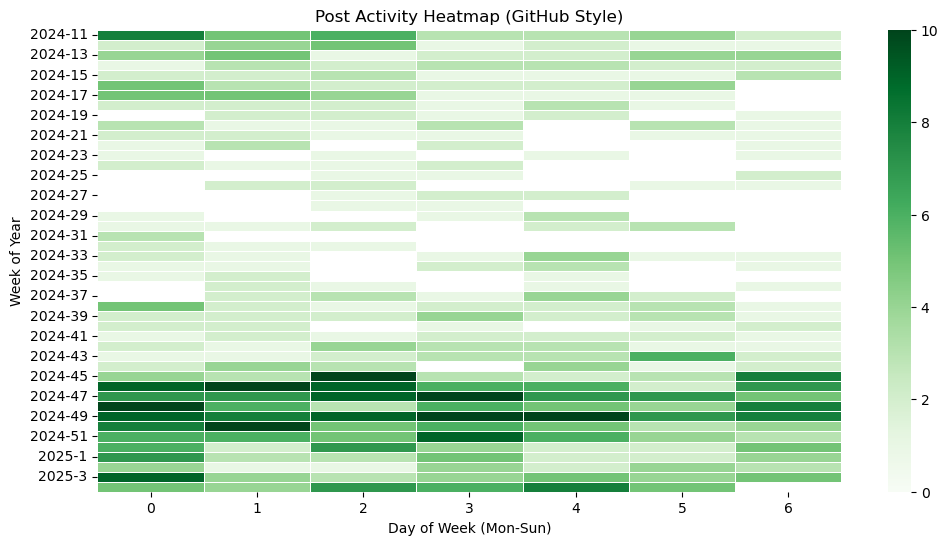

In [52]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, cmap="Greens", linewidths=0.5, linecolor="white", vmin=0, vmax=10)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Post Activity Heatmap (GitHub Style)")

plt.show()

In [59]:
def get_top_comments(post_id, limit=100):
    """
    Function to fetch the top comments for a given Reddit post by post_id.
    """
    try:
        # Fetch the submission (post) using its ID
        submission = reddit.submission(id=post_id)
        
        # Get top comments (replace 'limit' with 200 to get the top 200 comments)
        submission.comments.replace_more(limit=0)  # Avoid "MoreComments" object
        top_comments = submission.comments.list()
        
        # Limit to the top 100 comments
        top_comments = top_comments[:limit]
        
        return [comment.body for comment in top_comments]  # Return the comment bodies
    
    except Exception as e:
        print(f"Error fetching comments for post {post_id}: {e}")
        return []

# Example to add top comments to your DataFrame
def run_func(df):
    top_comments_list = []
    for post_id in df['post_id']:
        if post_id:
            comments = get_top_comments(post_id)
        else:
            comments = []
        top_comments_list.append(comments)
    return top_comments_list

In [60]:
top_comments_list = run_func(df_filtered)

Fetching: GET https://oauth.reddit.com/comments/1bc1p7r/ at 1741692721.6857786
Data: None
Params: {'limit': 2048, 'raw_json': 1, 'sort': 'confidence'}
Response: 200 (49206 bytes) (rst-476:rem-999.0:used-1 ratelimit) at 1741692724.0134697
Fetching: GET https://oauth.reddit.com/comments/1bc3une/ at 1741692724.0309906
Data: None
Params: {'limit': 2048, 'raw_json': 1, 'sort': 'confidence'}
Response: 200 (15553 bytes) (rst-474:rem-998.0:used-2 ratelimit) at 1741692725.2028384
Fetching: GET https://oauth.reddit.com/comments/1bc58w0/ at 1741692725.214901
Data: None
Params: {'limit': 2048, 'raw_json': 1, 'sort': 'confidence'}
Response: 200 (96446 bytes) (rst-473:rem-997.0:used-3 ratelimit) at 1741692728.7334898
Fetching: GET https://oauth.reddit.com/comments/1bc6dk6/ at 1741692728.7617183
Data: None
Params: {'limit': 2048, 'raw_json': 1, 'sort': 'confidence'}
Response: 200 (32498 bytes) (rst-469:rem-996.0:used-4 ratelimit) at 1741692730.085478
Fetching: GET https://oauth.reddit.com/comments/1b

In [61]:
df_filtered['top_comments'] = top_comments_list

In [62]:
df_filtered

,post_id,title,body,author,upvotes,downvotes,score,num_comments,url,created_at,subreddit,date_created,is_relevant,year,week,day,iso_year,iso_week,top_comments
10,1bc1p7r,"MicroStrategy acquires additional 12,000 BTC a...",No text body (link post),InfinityLife,1892,0,1892,282,https://i.redd.it/jbgpax4t4pnc1.png,2024-03-11 12:11:51+00:00,Bitcoin,2024-03-11,Yes.,2024,11,0,2024,11,"[for anybody wondering if it's ""too late"" to c..."
1,1bc3une,"MicroStrategy has acquired an additional 12,00...",No text body (link post),Vipu2,486,0,486,75,https://twitter.com/saylor/status/176715887029...,2024-03-11 13:59:44+00:00,CryptoCurrency,2024-03-11,Yes,2024,11,0,2024,11,[I feel like he’s discovered some kind of infi...
0,1bc58w0,No one still gives a shit about BTC. (bullish),I'm celebrating new BTC all time highs today a...,ultron290196,1962,0,1962,691,https://www.reddit.com/r/Bitcoin/comments/1bc5...,2024-03-11 15:01:46+00:00,Bitcoin,2024-03-11,**Yes**\n\nThe post discusses Bitcoin's market...,2024,11,0,2024,11,[Number 2 is a strong factor. People are just ...
7,1bc6dk6,"4 years ago today, bitcoin was $4,000",anyone remember the march 2020 era?,ILostHalfaBTC,1081,0,1081,187,https://www.reddit.com/r/Bitcoin/comments/1bc6...,2024-03-11 15:50:49+00:00,Bitcoin,2024-03-11,Yes.,2024,11,0,2024,11,[If I would've bought all the Bitcoin I bought...
4,1bc9lsq,Be ready for big dips even if we are in a bull...,Crypto is still a volatile rollercoaster marke...,fan_of_hakiksexydays,890,0,890,238,https://www.reddit.com/r/CryptoCurrency/commen...,2024-03-11 18:00:06+00:00,CryptoCurrency,2024-03-11,**Yes**\n\nThis Reddit post discusses historic...,2024,11,0,2024,11,[I just hope these theoretical dips happen whe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,1i9hicj,Throwback to 2010: Someone Regretting 'Only' M...,No text body (link post),kirtash93,926,0,926,89,https://www.reddit.com/gallery/1i9hicj,2025-01-25 07:07:01+00:00,CryptoCurrency,2025-01-25,Yes. The post is about mining and the value of...,2025,4,5,2025,4,"[Hindsight is nauseating, Wonder at what price..."
1738,1i9ljf9,BTC,No text body (link post),Late-Election-4690,3489,0,3489,59,https://i.redd.it/mei5efrcr4fe1.jpeg,2025-01-25 12:04:03+00:00,Bitcoin,2025-01-25,Yes.,2025,4,5,2025,4,[1971 was just the last nail in the coffin. Th...
1734,1i9q2gt,'A mockery': Trump's new meme-coin sparks ange...,No text body (link post),4inalfantasy,1760,0,1760,341,https://www.bbc.com/news/articles/crlkjejpwr8o,2025-01-25 16:02:00+00:00,CryptoCurrency,2025-01-25,Yes. The post appears to be related to a recen...,2025,4,5,2025,4,[tldr; US President Donald Trump has faced cri...
1740,1i9qktl,Epic new Bitcoin ad. They keep getting better 🙌,No text body (link post),BitCypher84,1634,0,1634,156,https://v.redd.it/2blk43pq16fe1,2025-01-25 16:24:24+00:00,Bitcoin,2025-01-25,Yes,2025,4,5,2025,4,[Gladiators juxtaposed with NFL players is so ...


In [65]:
df_filtered.to_parquet(r'C:\Users\leoqi\Desktop\NUS_Modules\DSE4211\DSE4211-Group-BTC-Day-Trading\data\raw\reddit_relevant_posts.parquet', index=False)

In [6]:
df_filtered = pd.read_parquet(r'..\data\raw\reddit_relevant_posts.parquet')

In [14]:
class Sentiment(BaseModel):
    """ Sentiment of Bitcoin outlook from the financial news"""
    sentiment: Literal["positive", "negative", "neutral"]

    @classmethod
    def from_response(cls, response: str):
        """Parse and validate response from Ollama"""
        try:
            normalized_response = response.strip().lower()  
            if normalized_response not in {"positive", "negative", "neutral"}:
                raise ValueError(f"Unexpected sentiment: {normalized_response}")
            return cls(sentiment=normalized_response)
        except (ValidationError, ValueError) as e:
            print(f"Error parsing response: {e}; Response: {response}")
            return cls(sentiment="neutral")  # fallback to neutral


In [15]:
slang_definitions = """
1. Stonk
Stonk means stock. This term originated with an internment meme of a suited man (presumably a trader) standing in front of some numbers and a big orange arrow, all of it titled “stonks.” The meme was a cheeky reference to making bad financial decisions, sort of like someone who cannot even pronounce stocks correctly.

2. Diamond Hands
The term “diamond hands” refers to holding on to a stock or option despite volatility and losses in the confidence that its price will eventually increase. On memes, the phrase is represented with emojis of a diamond and then hands. The term actually indicates risk taking, and is sometimes the folly of stubbornly holding on to a stock or option until the bitter end, even when the ship should have been abandoned long ago. Whether having diamond hands is good or bad will probably depend on the final outcome of the ticker symbol.

3. Tendies
This one has a bizarre etymology (to say the least). Tendies is short for chicken tenders, and it comes from 4Chan as part of reference to grown men living with their mothers—men who would be rewarded for good behavior and self-sufficiency with GBP (good boy points), which they could then redeem for their favorite food: chicken tenders (we warned you the background was a little strange). The term moved to r/wallstreetbets where members used it self-deprecatingly in reference to their own living arrangements. Eventually, the term came to be associated with money or profit made from stock trading and options trading, which is how it’s most frequently used today.

4. YOLO
You only live once. This term actually seems to originate from the notion encapsulated in the Latin “carpe diem” (seize the day). It became popularized around 2012, in large part because of its usage in the rap song “The Motto” by Drake and Lil Wayne. In internet parlance, YOLO often humorously refers to an extremely risky choice that seems simultaneously laughable and dangerous. On Wallstreetbets, YOLO could apply to a trade where an investor puts in the majority of their capital—for instance, putting 95 percent of their account into Dogecoin.

Woman Investing In Stocks Scaled

5. HODL
HODL might seem to stand for Hold on For Dear Life, the encapsulated notion of which is also popularly expressed in the phrase Hold the Line. But actually, HODL really came about because of a typo for hold.

It all started on December 18th in 2013, when user GameKyuubi posted an inebriated, typo-filled, and only partially coherent internet rant about his poor trading skills, and how it would be better for people like himself to avoid day trading and stick to a buy and hold principle. The title of the post was I AM HODLING, and the rest is history. Images from Braveheart, 300, and Game of Thrones have provided the meme substance for promoters of the HODL principle—that is, avoid trading decisions based on short term swings, which can be simply ruinous for stock investors who do not know what they are doing. The HODL principle is particularly discussed in the cryptocurrency venue, where it contrasts against principles such as FOMO (the fear of missing out).

6. To the Moon
As you might guess, this term indicates that a given stock is going to have wild success in terms of its price increase, resulting in a lot of tendies for investors. In emojis, this phrase is indicated by rockets. Gamestock and AMC Theatres are just two examples of stock that members celebrated going to the moon.

If you see a sizable number of community members using this phrase to discuss a ticker symbol, it might be something you want to pay attention to. Of course, there are certainly other factors as to whether or not that translates to tangible success beyond the reddit threads.

Take your portfolio to the moon today and join Infinity Investing! As a member, you’ll gain exclusive access to expert stock investing tips and a network of like-minded investors. 

7. Apes Together Strong
Often represented with a gorilla emoji, the “apes together strong” phrase comes from Planet of the Apes. Apes are retail investors who feel bullish (optimistic) about a particular stock that is expected by short sellers to drop in price. If enough retail investors band together, they can be strong enough to drive up the price of the stock and defeat the goal of the short sellers, who want the price to fall (short selling involves borrowing a stock, selling it, and then selling it back to the investor after the price has dropped).

Apes together strong encapsulates the idea of the proverbial little man uniting with other everyday people to defeat more powerful institutional investors. This was seen recently in 2021 with GameStop and AMC Theaters.

8. Bears
A bear investor is one who feels bearish about a particular stock (or even the stock market in general). They are somewhat of a debbie downer on the r/wallstreetbets forum, and may become the butt end of jokes and insults, since most community members are looking for that next stock or cryptocurrency to go to the moon.

Tangentially, the phrases bear market and bull market relate to whether the market is going up and down. Since bears strike by coming down on their target, a bear market suggests decreasing stock prices. Because bulls gore their target by moving their horns upward, a bull market suggests increasing prices. Though this imagery is not unique to Wallstreetbets, it’s probably one of the few places where a bearish perspective on a security or the market in general can earn someone the appellation of being a bear themselves.

9. Buy High Sell Low
This is a joke about losses, expressed in a joking reference to the traditional, sensible, and simple advice of buy low and sell high. Someone who bought high and sold low has failed miserably at turning a particular trade into something financially profitable, leaving them at the mercy of jabs from other community members.

10. Buy the Dip
For members who feel overall bullish about a particular stop, slight dips in its generally upward price are a momentary respite to buy the stock at a discount. Buying the dip expresses this timely trade, and is often paired with Diamond Hands and To the Moon for a potent meme trio.

11. Paper Hands
Paper hands are the opposite of diamond hands, referencing traders who unload their shares at the first sign of bad news. As you can imagine, the connotation here is somewhat negative in its indication of a trader who acts too quickly, out of fear.

12. We Like the Stock
This phrase comes from Jim Cramer, who was the host of Mad Money on CNBC. The simple phrase is used to indicate a favorable attitude toward holding a stock, much in the same way that Cramer would have used the phrase. During the Game Stop Short Squeeze, Cramer actually said “WallStreetBets is too powerful, and trying to bet against them right now is just giving them more ammo,” an accolade that many a community member probably appreciated.

Use these definitions when analyzing the sentiment of the comments 
"""



In [16]:
def get_sentiment(post_title, post_body, comments):
    prompt = f"""

    {slang_definitions}
    
    Given the title and body of a post and a list of comments in response, analyze the overall sentiment of the comments to determine if the general outlook on Bitcoin or BTC is positive, negative, or neutral.

    Post Title: "{post_title}"
    Post Body: "{post_body}"
    Comments:
    {comments}

    Provide a single-word label: positive, negative, or neutral in lowercase.
    Only return the label without additional text.

    """

    response = ollama.chat(model=model_name, messages=[{"role": "user", "content": prompt}])
    
    return Sentiment.from_response(response["message"]["content"])

In [17]:
df_filtered["overall_sentiment"] = df_filtered.apply(lambda row: get_sentiment(row["title"], row["body"], row["top_comments"]), axis=1)

Error parsing response: Unexpected sentiment: bullish; Response: bullish
Error parsing response: Unexpected sentiment: bullish; Response: bullish
Error parsing response: Unexpected sentiment: bullish; Response: bullish
Error parsing response: Unexpected sentiment: bullish; Response: bullish


In [20]:
df_filtered["overall_sentiment"] = df_filtered["overall_sentiment"].apply(lambda x: x.sentiment if isinstance(x, Sentiment) else x)

In [21]:
df_filtered

,post_id,title,body,author,upvotes,downvotes,score,num_comments,url,created_at,subreddit,date_created,is_relevant,year,week,day,iso_year,iso_week,top_comments,overall_sentiment
0,1bc1p7r,"MicroStrategy acquires additional 12,000 BTC a...",No text body (link post),InfinityLife,1892,0,1892,282,https://i.redd.it/jbgpax4t4pnc1.png,2024-03-11 12:11:51+00:00,Bitcoin,2024-03-11,Yes.,2024,11,0,2024,11,"[for anybody wondering if it's ""too late"" to c...",positive
1,1bc3une,"MicroStrategy has acquired an additional 12,00...",No text body (link post),Vipu2,486,0,486,75,https://twitter.com/saylor/status/176715887029...,2024-03-11 13:59:44+00:00,CryptoCurrency,2024-03-11,Yes,2024,11,0,2024,11,[I feel like he’s discovered some kind of infi...,positive
2,1bc58w0,No one still gives a shit about BTC. (bullish),I'm celebrating new BTC all time highs today a...,ultron290196,1962,0,1962,691,https://www.reddit.com/r/Bitcoin/comments/1bc5...,2024-03-11 15:01:46+00:00,Bitcoin,2024-03-11,**Yes**\n\nThe post discusses Bitcoin's market...,2024,11,0,2024,11,[Number 2 is a strong factor. People are just ...,positive
3,1bc6dk6,"4 years ago today, bitcoin was $4,000",anyone remember the march 2020 era?,ILostHalfaBTC,1081,0,1081,187,https://www.reddit.com/r/Bitcoin/comments/1bc6...,2024-03-11 15:50:49+00:00,Bitcoin,2024-03-11,Yes.,2024,11,0,2024,11,[If I would've bought all the Bitcoin I bought...,neutral
4,1bc9lsq,Be ready for big dips even if we are in a bull...,Crypto is still a volatile rollercoaster marke...,fan_of_hakiksexydays,890,0,890,238,https://www.reddit.com/r/CryptoCurrency/commen...,2024-03-11 18:00:06+00:00,CryptoCurrency,2024-03-11,**Yes**\n\nThis Reddit post discusses historic...,2024,11,0,2024,11,[I just hope these theoretical dips happen whe...,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,1i9hicj,Throwback to 2010: Someone Regretting 'Only' M...,No text body (link post),kirtash93,926,0,926,89,https://www.reddit.com/gallery/1i9hicj,2025-01-25 07:07:01+00:00,CryptoCurrency,2025-01-25,Yes. The post is about mining and the value of...,2025,4,5,2025,4,"[Hindsight is nauseating, Wonder at what price...",neutral
830,1i9ljf9,BTC,No text body (link post),Late-Election-4690,3489,0,3489,59,https://i.redd.it/mei5efrcr4fe1.jpeg,2025-01-25 12:04:03+00:00,Bitcoin,2025-01-25,Yes.,2025,4,5,2025,4,[1971 was just the last nail in the coffin. Th...,neutral
831,1i9q2gt,'A mockery': Trump's new meme-coin sparks ange...,No text body (link post),4inalfantasy,1760,0,1760,341,https://www.bbc.com/news/articles/crlkjejpwr8o,2025-01-25 16:02:00+00:00,CryptoCurrency,2025-01-25,Yes. The post appears to be related to a recen...,2025,4,5,2025,4,[tldr; US President Donald Trump has faced cri...,negative
832,1i9qktl,Epic new Bitcoin ad. They keep getting better 🙌,No text body (link post),BitCypher84,1634,0,1634,156,https://v.redd.it/2blk43pq16fe1,2025-01-25 16:24:24+00:00,Bitcoin,2025-01-25,Yes,2025,4,5,2025,4,[Gladiators juxtaposed with NFL players is so ...,negative


In [22]:
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
df_filtered["sentiment_score"] = df_filtered["overall_sentiment"].map(sentiment_mapping)

iso_calendar = df_filtered['date_created'].dt.isocalendar()
df_filtered['year'] = iso_calendar.year  # Use ISO year instead of dt.year
df_filtered['week'] = iso_calendar.week
df_filtered['day'] = df_filtered['date_created'].dt.dayofweek

heatmap_data_2 = df_filtered.groupby(["year", "week", "day"])["sentiment_score"].mean().unstack()

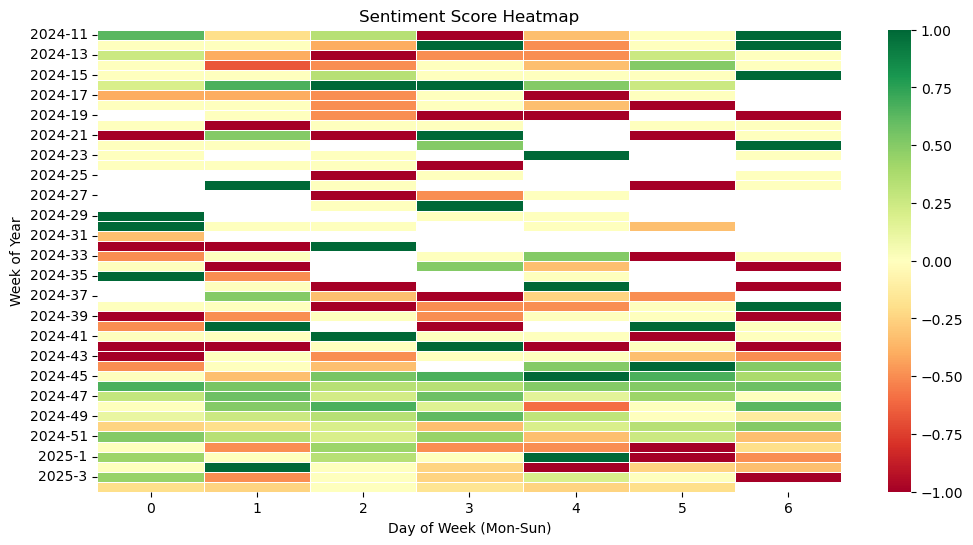

In [23]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data_2, cmap="RdYlGn", linewidths=0.5, linecolor="white", center=0, vmin=-1, vmax=1)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Sentiment Score Heatmap")
plt.show()

In [24]:
df_filtered.to_parquet(r'..\data\processed\reddit_relevant_posts_with_sentiment.parquet', index=False)

In [21]:
rate_limit_info = reddit.auth.limits
print(rate_limit_info)

{'remaining': 960.0, 'reset_timestamp': 1741526399.834681, 'used': 40}


In [22]:
from datetime import datetime

reset_time = pd.to_datetime(rate_limit_info['reset_timestamp'],unit = "s",utc = True).tz_convert("Asia/Singapore")  # Convert to UTC time
print("Rate limit resets at (SGT):", reset_time.strftime('%Y-%m-%d %H:%M:%S %Z'))

Rate limit resets at (SGT): 2025-03-09 21:19:59 +08
